## Transductive Graph Machine Learning - Edge Classification (30 minutes)

Towards understanding complex urban systems, non-linear learning approaches such as deep learning has gained popularity. Urban streets are intrinsically complex, showing self-similarity and self-organisation across scale. 
On a more fundamental level, streets function as multi-faceted urban elements that feature a rich diversity of social, economic, and environmental activities.
Correspondingly, the task of predicting street category (e.g. primary, secondary, or arterial) is a complex endeavour since streets categories depend not only on the geometric properties of streets but also on their semantic and contextual dimensions.
Reliable estimates for street categories provide many useful applications and use cases, not limited to, understanding urban hierarchy, clustering and segmentation of road networks, estimating urban air and noise pollution, modelling urban mobility flows, and assessing disaster response.

This notebook demonstrates how we can train a simple Graph Convolutional Network (GCN) model (Kipf, 2016) to predict road categories for cities. 

This notebook uses the following datasets which have been provided as part of the repository. Please clone the repository or download the files to follow along:
- Paris node (100m) attribute data (GUN)
- Paris edge (100m) attribute data (GUN)

### Installation
PyTorch Geometric is a library built on top of the PyTorch deep learning framework. It provides an intuitive interface to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data. Please follow the installation instructions at the following links to find the right commands to run for your operating system:

Please run the following lines to install PyTorch and PyTorch Geometric. We install the current latest version PyTorch 1.13.0 and specify cuda as None (cpu):
```
!conda install pytorch torchvision torchaudio -c pytorch --yes
!python -m pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+None.html
!python -m pip install torch-sparse==0.6.13 -f https://pytorch-geometric.com/whl/torch-1.13.0+None.html
!python -m pip install torch-geometric
```

In [3]:
# # Install pytorch geometric from command line
# !conda install pytorch torchvision torchaudio -c pytorch --yes
# !python -m pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+None.html
# !python -m pip install torch-sparse==0.6.13 -f https://pytorch-geometric.com/whl/torch-1.13.0+None.html
# !python -m pip install torch-geometric

### Import packages for deep learning
If everything goes well, we should be able to import all the external packages below with no issues.

In [1]:
# Import base packages
import os
import json
import pickle
import argparse

# Import external packages
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from collections import Counter
import torch.nn.functional as F
import torch_geometric.transforms as T
from sklearn.preprocessing import StandardScaler

# from data_class import MyDataset
# from models import GCN, GATv2, GraphSAGE

### Read in Paris node and edge attributes from the GUN dataset

We begin by importing Paris node and edge attribute datasets from the GUN dataset. Node indicators are computed for a buffer radius of 100 metres. 

After reading in our data, we do some basic preprocessing to convert them into PyTorch geometric data objects for graph neural network training. 

In [6]:
# # Read nodes data
# paris_100m_nodes = gpd.read_file('./GUN/paris100m.geojson')
# paris_100m_nodes = paris_100m_nodes.set_index('osmid')

# # Read edges data
# paris_100m_edges = pd.read_csv('./GUN/paris100m.csv', index_col=0)

# # Visualise columns of edge dataframe
# paris_100m_edges.head()[['osmid', 'highway', 'geometry']]

,osmid,highway,geometry
0,"(2569, 2569, 2569)","('tertiary', 'tertiary', 'tertiary')","LINESTRING (2.3694427 48.8215316, 2.3694159 48..."
1,"(34855904, 34855904, 34855904, 34855904)","('primary', 'primary', 'primary', 'primary')","LINESTRING (2.3694427 48.8215316, 2.3697313 48..."
2,"(40001847, 40001847, 40001847)","('secondary', 'secondary', 'secondary')","LINESTRING (2.3694427 48.8215316, 2.3693587 48..."
3,"(41361996, 41361996, 41361996, 41361996, 58441...","('secondary', 'secondary', 'secondary', 'secon...","LINESTRING (2.3694427 48.8215316, 2.3695358 48..."
4,"(370869408, 370869408)","('primary', 'primary')","LINESTRING (2.3694427 48.8215316, 2.3692848 48..."


### Data Preprocessing
As noted from the first entries of our edge dataframe, some edges consist of multiple original edges. This is not an error but rather an outcome of graph simplification applied earlier. However, this is a problem for edge classification since the GNN model predicts only one label (even if it can be multi-class) per edge. Therefore, we need to convert edges into single entries. We adopt a simple majority rule, returning the most frequent label in each entry. In the case there are ties, the first entry is chosen. This assumption makes intuitive sense as if an edge is classified mainly as 'secondary' with some segments of 'primary/tertiary' road, it would not be uncommon for planners classifying the road to assign it a label of 'secondary'. Below we create a function `convert_labels` to convert multi-label entries into single label entries. We create a new data column `Road Type` in our edges dataframe which will serve as our target variable of interest. 

In [13]:
# Define Functions to Convert Edge to One Type

def most_frequent(string_list):
    """Function to count the number of most occurring labels on an edge and relabel according to most frequent label.

    Args:
        string_list (list): A string of labels of road classification types

    Returns:
        str: The most common label along an edge
    """
    occurence_count = Counter(string_list)
    if occurence_count.most_common(1)[0][0] == 'unclassified':
        try:
            return occurence_count.most_common(2)[1][0]
        except IndexError:
            return 'unclassified'
    else: 
        return occurence_count.most_common(1)[0][0]
    
def convert_labels(row):
    """Function to apply to each edge label, accounting for single entries. If only one entry, skips to next row.

    Args:
        row (str): Entries consisting of string of edge labels

    Returns:
        str: Most commmon label along an edge. 
    """
    try:
        list_of_roads = eval(row)
        return most_frequent(list_of_roads)
        
    except NameError:
        return row
    
# Create new relabelled column `Road Type`
paris_100m_edges['Road Type'] = paris_100m_edges['highway'].apply(convert_labels)

# Visualise new edge dataframe
paris_100m_edges.head()[['osmid', 'highway', 'Road Type', 'geometry']]

,osmid,highway,Road Type,geometry
0,"(2569, 2569, 2569)","('tertiary', 'tertiary', 'tertiary')",tertiary,"LINESTRING (2.3694427 48.8215316, 2.3694159 48..."
1,"(34855904, 34855904, 34855904, 34855904)","('primary', 'primary', 'primary', 'primary')",primary,"LINESTRING (2.3694427 48.8215316, 2.3697313 48..."
2,"(40001847, 40001847, 40001847)","('secondary', 'secondary', 'secondary')",secondary,"LINESTRING (2.3694427 48.8215316, 2.3693587 48..."
3,"(41361996, 41361996, 41361996, 41361996, 58441...","('secondary', 'secondary', 'secondary', 'secon...",secondary,"LINESTRING (2.3694427 48.8215316, 2.3695358 48..."
4,"(370869408, 370869408)","('primary', 'primary')",primary,"LINESTRING (2.3694427 48.8215316, 2.3692848 48..."


As shown above, the new column `Road Type` corresponds to the most frequent entry in each column. 

The next step involves converting our `Road Type` column into numerical values. This is necessary since GNN models that rely on backpropagation of gradients require numeric values for optimisation. Based on [OSM Taginfo](https://taginfo.openstreetmap.org/) descriptions, We relabel `Road Type` categories according to five hierarchical classes: national (1); regional (2); precinct (3); neighbourhood (4); and local access roads (5). 

In [16]:
# Relabel categories according to OSM TagInfo definition
paris_100m_edges['Road Type'] = paris_100m_edges['Road Type'].replace({'service':5,
                                                            'services':5,
                                                            'residential':4,
                                                            'primary':1,
                                                            'secondary':2,
                                                            'tertiary':2,
                                                            'unclassified':4,
                                                            'primary_link':3,
                                                            'secondary_link':3,
                                                            'trunk':2,
                                                            'motorway_link':3,
                                                            'motorway':1,
                                                            'trunk_link':3,
                                                            'tertiary_link':3,
                                                            'living_street':4,
                                                            'footway':4,
                                                            'cycleway':4,
                                                            'pedestrian':4,
                                                            'bus_stop':3,
                                                            'path':2,
                                                            'track':5,
                                                            'busway':3,
                                                            'crossing':4
                                                            })

# Remove roads under construction, and with no description on OSM TagInfo (e.g., steps).
paris_100m_edges = paris_100m_edges[(paris_100m_edges['Road Type']!='construction') & (paris_100m_edges['Road Type']!='steps')]

# We show the final number of counts for each category
paris_100m_edges['Road Type'].value_counts()


4    22280
5    12451
2    10067
1     6140
3      941
Name: Road Type, dtype: int64

The number of classes in each category are on average quite well balanced except for neighbourhood (3) labels. To qualify our interpretations, it will be necessary to understand how well the model can predict labels for each class. Later on in our analysis pipeline, we will examine receiver operating curves and model's performance on each respective class. We first proceed to set up our data object, train, and validate our model. 

### Preparing PyTorch Geometric Data Object

At its core, PyTorch Geometric Data Objects function similar to a standard PyTorch data object. It provides a simple class to store essential data training and validation information. For example, it includes node attributes, train and validation splits and masks, target labels, and edge/adjacency information for networks. We go through each step in detail below to prepare each object before combining them into a PyTorch Geometric Data object. 

#### Target label preparation
The easiest item to prepare is our target labels. All we need to do is subtract one from each class since the first class should correspond to `0`. After subtracting 1, our target label is complete. 

In [47]:
# Prepare target label
label = paris_100m_edges['Road Type'].values - 1
label = label.astype(float)

#### Prepare adjacency information in [COO](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs) format. 
COO corresponds a way of representing edges by placing start and end nodes as adjacent lists. This results in a tensor of shape = (2, num_edges). Where the first index corresponds to positions for the start and end node ids respectively. 

In [27]:
# Prepare edge index. First match with index position then convert to torch tensor. 
node_to_id = {}
for i,node in enumerate(paris_100m_nodes.index):
    node_to_id[node] = i
    
# Second, create tensor list for start and end nodes
start_node = [node_to_id[i] for i in paris_100m_edges['u'].values]
end_node = [node_to_id[i] for i in paris_100m_edges['v'].values]
start = torch.Tensor(start_node).to(torch.long)
end = torch.Tensor(end_node).to(torch.long)
edge_index = torch.stack([start, end], dim=0)

# Show edge_index
edge_index

tensor([[    0,     0,     0,  ..., 18043, 18044, 18045],
        [    1,   220, 10925,  ..., 15792, 16898,  9977]])

### Prepare feature attribute matrix
The feature attribute matrix corresponds to the attributes for each node in our graph. In this case, we use the entire set of feature attributes (metric/topological/contextual/semantic) and exclude only the `geometry` column. We also standardise our variables since some of them are on a different scale. Our final attribute matrix consists of 18,046 nodes and 39 corresponding attribute fields for each node. 

In [37]:
# Subset dataframe to features of interest
x = np.array(paris_100m_nodes.iloc[:,:-1].values)

# Normalise features
scale = StandardScaler()
x = scale.fit_transform(x)

print(x.shape)

(18046, 39)


### Set up PyTorch Geometric Data Object
With all our pieces in place, we can now combine all of them to create our data object. This data object will be fed into our GNN model for training and evaluation. The first lines import the necessary libraries and modules to create our data object. Following, we define a simple list that corresponds to a range of numbers from 0 to the total number of edges in our graph: 0, 1, 2, ..., N_EDGES. We use this list of numbers to perform a random train and test split with the `train_test_split` function from scikit learn library.

In [52]:
# Import torch, training modules and classes
import torch
from torch_geometric.data import InMemoryDataset, Data 
from sklearn.model_selection import train_test_split

# Set manual seed = 0 to allow reproducible results
torch.manual_seed(0)

# Create range of numbers for edge index list(0,1,..., no_of_edges) for subsetting and random split 
indices = list(range(len(paris_100m_edges)))
    
class MyDataset(InMemoryDataset):
    def __init__(self, edge_index, attribute_data, edges_data, x, label, indices, transform=None):
        super(MyDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = len(attribute_data)
        data.num_edges = len(edges_data)
        
        # embedding 
        data.x = torch.from_numpy(x).type(torch.float32)
        
        # labels
        y = torch.from_numpy(label).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 5 # five main highway categories

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test, indices_train, indices_test, = train_test_split(edge_index.T, 
                                                                                        label,
                                                                                        indices,
                                                                                        test_size=0.1, 
                                                                                        random_state=99)
        
        
        # create train and test masks for data
        train_mask = torch.zeros(data.num_edges, dtype=torch.bool)
        test_mask = torch.zeros(data.num_edges, dtype=torch.bool)
        train_mask[indices_train] = True
        test_mask[indices_test] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

def _download(self):
    return

def _process(self):
    return

def __repr__(self):
    return '{}()'.format(self.__class__.__name__)

# Set torch device to cuda if available or else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate Dataset 
dataset = MyDataset(edge_index, paris_100m_nodes, paris_100m_edges, x, label, indices)
data = dataset[0]
data = data.to(device)

# Show data object
data

Data(edge_index=[2, 51879], num_nodes=18046, num_edges=51879, x=[18046, 39], y=[51879], num_classes=5, train_mask=[51879], test_mask=[51879])

### Model Architecture Graph Attention Network (GAT) 

With our data object successfully set up, all we need to do now is to define our model and begin training. It is straightforward to implement different GNN architectures with the torch geometric library. For GAT, we simply import the GATv2Conv module from `torch_geometric` and plug it into our model framework. 

In [111]:
# Import helper and utility functions from torch. Import GCNConv class. 
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch.optim import lr_scheduler

# Define model hyper parameters
HIDDEN_DIM = 64
LR = 0.01
EPOCH = 500

class GATv2(torch.nn.Module):
    def __init__(self, hidden_layer, data, heads=4):
        super(GATv2, self).__init__()
        self.gat1 = GATv2Conv(data.num_features, hidden_layer, heads=heads)
        self.gat2 = GATv2Conv(hidden_layer*heads, hidden_layer, heads=1)
        self.linear = nn.Linear(hidden_layer*2, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        out= self.gat1(x, edge_index)
        out = F.elu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.gat2(out, edge_index)

        src, dst = edge_index
        out = torch.concat((out[src], out[dst]),dim=1)
        out = self.linear(out)
        
        return F.softmax(out, dim=1)

# Initialise GCN model instance
model = GATv2(HIDDEN_DIM, data).to(device) 

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print(model)

GATv2(
  (gat1): GATv2Conv(39, 64, heads=4)
  (gat2): GATv2Conv(256, 64, heads=1)
  (linear): Linear(in_features=128, out_features=5, bias=True)
)


### Model Training and Evaluation

We begin training our GAT model with a learning rate of 0.01 and specifying 500 iterations. We report training and testing loss for each epoch (iteration). We also evaluate our model on predicting unseen edges for every 20 round interval. 

In [112]:
# scheduler = ReduceLROnPlateau(optimizer, 'min')
epoch_train_val = {}

for epoch in range(1,EPOCH+1):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    training_loss = torch.sum(train_loss)
    train_loss.backward()
    optimizer.step()

    model.eval()
    pred = model(data)
    test_loss = criterion(pred[data.test_mask], data.y[data.test_mask])
    test_loss = torch.sum(test_loss)
    # scheduler.step(test_loss)

    epoch_train_val[epoch] = {'training_loss':training_loss.item(), 'test_loss' :test_loss.item()}

    print(f'Epoch: {epoch}/{EPOCH}- Training Loss: {training_loss}; Testing Loss: {test_loss}')

    if epoch % 20 == 0:
        pred = model(data).argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())

        print(f'Validation accuracy: {acc}.')

Epoch: 1/500- Training Loss: 1.6064088344573975; Testing Loss: 1.4291023015975952
Epoch: 2/500- Training Loss: 1.431700348854065; Testing Loss: 1.3718469142913818
Epoch: 3/500- Training Loss: 1.378851294517517; Testing Loss: 1.3503613471984863
Epoch: 4/500- Training Loss: 1.3595061302185059; Testing Loss: 1.3434410095214844
Epoch: 5/500- Training Loss: 1.3533434867858887; Testing Loss: 1.3356459140777588
Epoch: 6/500- Training Loss: 1.3440150022506714; Testing Loss: 1.3302868604660034
Epoch: 7/500- Training Loss: 1.3399527072906494; Testing Loss: 1.329826831817627
Epoch: 8/500- Training Loss: 1.3381998538970947; Testing Loss: 1.32177734375
Epoch: 9/500- Training Loss: 1.3314638137817383; Testing Loss: 1.3143434524536133
Epoch: 10/500- Training Loss: 1.3274346590042114; Testing Loss: 1.3136310577392578
Epoch: 11/500- Training Loss: 1.325979232788086; Testing Loss: 1.3140093088150024
Epoch: 12/500- Training Loss: 1.326476812362671; Testing Loss: 1.312303900718689
Epoch: 13/500- Training 

### Model Evaluation and Visualisation
Overall, our model achieves 73.7% prediction accuracy on our validation set. This is not bad for a simple GAT model. We can do a quick visualisation of our training results. Overall, we can see that training and validation loss decreases quickly. In addition, validation loss remains below training loss, a sign that the model is not overfitting the dataset.  

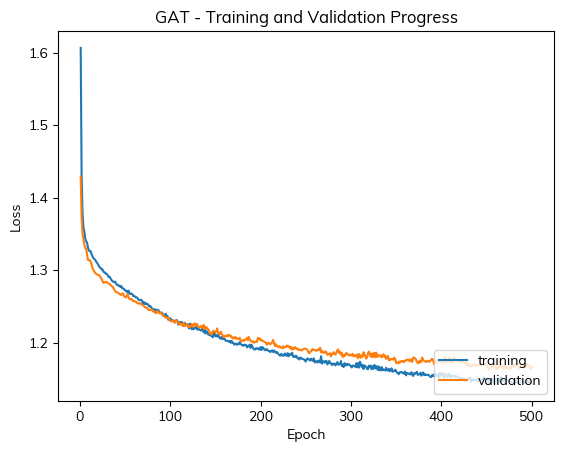

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

train_loss = pd.DataFrame(epoch_train_val).transpose().reset_index()
lines = train_loss.plot.line(x='index', y=['training_loss', 'test_loss'])
plt.title('GAT - Training and Validation Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

We can also look at model predictive performance on each class by examining the multi-class receiver operating characteristic curve. More specifically, we binarise our dataset according to target class of interest and implement a One versus Rest (OvR) approach to gauge prediction for each class. For example, if we are interesting in class 0 (Local Access Roads) then we set all instances of class 0 to `True` and all other classes (1-4) to `False`.

In [114]:
model.eval()
pred = model(data)

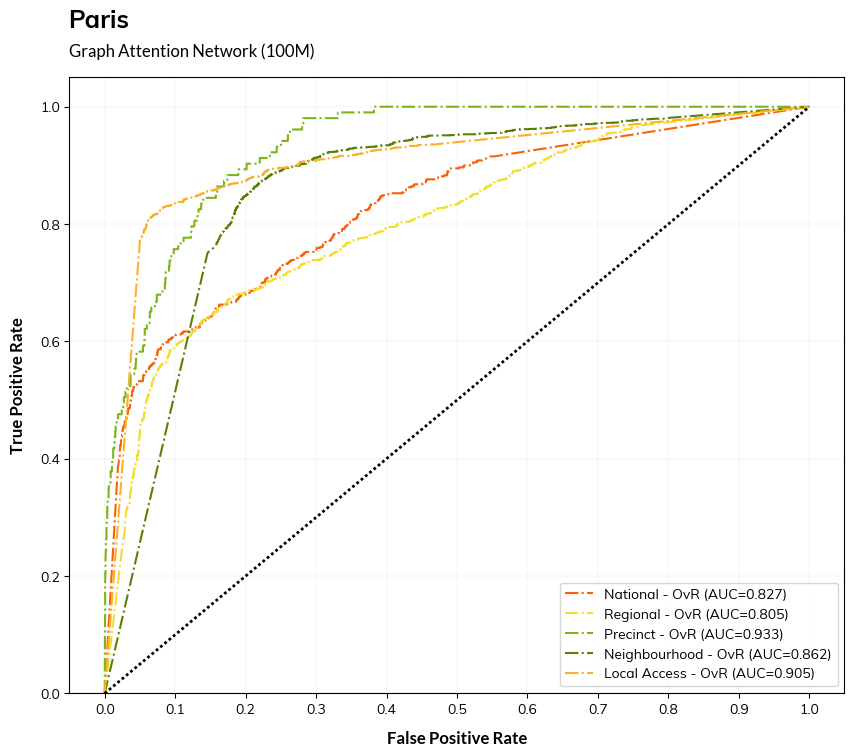

In [121]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, auc
import matplotlib.pyplot as plt

csfont = {'fontname':'Muli'}
hfont = {'fontname':'Lato'}

import matplotlib as mpl  
mpl.rc('font',family='Muli')
classes = ['National', 'Regional', 'Precinct', 'Neighbourhood', 'Local Access']
    
def plot_roc_curve(predictions = pred, data = data, class_nums = [0,1,2,3,4], color_list = ['#fb6107', '#f3de2c', '#7cb518', '#5c8001' ,'#fbb02d']):
    fig, ax = plt.subplots(figsize=(10,8))
    
    for class_num in class_nums:
        # Get tensor of probability
        y_probability = pred[:, class_num]
        y_probability = y_probability[data.test_mask]

        # Get tensor of predicted classes 
        y_predictions = pred.argmax(dim=1)
        y_predictions = y_predictions[data.test_mask]

        # Get OvR predicted class
        y_bin_predictions = y_predictions.clone()
        y_bin_predictions = [1 if i == class_num else 0 for i in y_bin_predictions]
        y_bin_predictions = torch.Tensor(y_bin_predictions)

        # Real OvR output 
        y_real = data.y[data.test_mask]
        binary_y_real = y_real.clone()
        binary_y_real = [1 if i == class_num else 0 for i in binary_y_real]
        binary_y_real = torch.Tensor(binary_y_real)

        binary_y_real = binary_y_real.detach().numpy()
        y_probability = y_probability.detach().numpy()
        
        fpr, tpr, _ = roc_curve(binary_y_real, y_probability)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label=f"{classes[class_num]} - OvR (AUC={round(roc_auc,3)})", color=color_list[class_num], linestyle='dashdot')       
    
    ax.plot([0, 1], [0, 1], color='black', linestyle=(0,(1.,1)), linewidth=2)
    ax.set_title('Graph Attention Network (100M)', fontsize=12, loc='left', pad=15, **hfont)
    ax.set_xticks(np.arange(0.0, 1.1, step=0.1))
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold', labelpad=10, **hfont)
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold', labelpad=10, **hfont)
    ax.set_ylim(0, 1.05)
    ax.grid(lw=0.2, alpha = 0.5)
    ax.legend(fontsize=10, loc='lower right')
    fig.suptitle('Paris', fontsize=18, x=0.154, y=0.965, fontweight='bold', **csfont)
    
    plt.show()
    # plt.savefig('./figures/paris_gat_100.png', dpi=300)

plot_roc_curve(predictions = pred, data = data)

Overall, our model performs reasonably well in predicting each class. Training for more epochs, more sophisticated model architectures, and hyperparameter tuning provide further directions for predictive performance improvement.

### Conclusion
We have come a long way! In this notebook, we demonstrate how we can employ attribute data from Urbanity for various graph machine learning tasks. Towards developing our understanding of complex urban systems, current developments in the fields of GeoAI and machine learning provide many novel opportunities to examine urban networks at an unprecedented scale. Future work will look at the effectiveness of inductive (cross city) graph neural network predictive tasks and examining underlying patterns in cities. 

### References

- Kipf, T. N., & Welling, M. (2016). Semi-supervised classification with graph convolutional networks. arXiv preprint arXiv:1609.02907.
- Hamilton, W., Ying, Z., & Leskovec, J. (2017). Inductive representation learning on large graphs. Advances in neural information processing systems, 30.
- Veličković, P., Cucurull, G., Casanova, A., Romero, A., Lio, P., & Bengio, Y. (2017). Graph attention networks. arXiv preprint arXiv:1710.10903.